# Covid-19 v České republice

verze s [API v3](https://onemocneni-aktualne.mzcr.cz/api/v3/docshttps://onemocneni-aktualne.mzcr.cz/api/v3/docs) 

TODO:
- přidat grafy specificky pro věkovou skupinu 40-49

In [1]:
from functions import get_days_back, get_residents, get_epidemic_data, \
                    get_vax_data, get_vax_data_simple, plot_vax_data,\
                    plot_positive_incidence, plot_tests, plot_rd, \
                    get_epidemic_vax_data, plot_djp_vax, plot_djp_vax_ratio, \
                    get_reinfection_data, plot_reinfection

days_back = get_days_back()
residents = get_residents()

print(f'Zobrazujeme data za {days_back} dní zpětně.')
print(f'Počítáme s {residents} obyvateli ČR.')

Zobrazujeme data za 91 dní zpětně.
Počítáme s 10701777 obyvateli ČR.


## Lidé s aktivní očkováním

Chceme získat alespoň přibližně množství lidí, kteří mají v daný den "aktivní" očkování. Aktivní je definováno jako:
- u Johnson vakcíny ne starší než 61 dní (2 měsíce)
- u ostatních vakcín druhá dávka ne starší než 182 dní (6 měsíců)
- u všech vakcín 3. booster dávka ne starší než 122 dní (4 měsíce)

Výsledkem je dataframe s aktuálním počtem lidí s aktivním očkováním v dané dni.

Data získána z CSV datové sady "COVID-19: Demografický přehled vykázaných očkování v čase". Do budoucna možno rožšířit i na danou věkovou skupinu.

In [2]:
vaxs = get_vax_data()

In [3]:
vaxs

,date,vaxs_active,vaxs_active_prcs
0,2020-12-29,1.0,9.344243e-08
1,2021-01-02,2.0,1.868849e-07
2,2021-01-05,3.0,2.803273e-07
3,2021-01-06,4.0,3.737697e-07
4,2021-01-08,5.0,4.672121e-07
...,...,...,...
465,2022-04-15,3080566.0,2.878556e-01
466,2022-04-16,3005933.0,2.808817e-01
467,2022-04-18,2856368.0,2.669060e-01
468,2022-04-19,2830887.0,2.645249e-01


In [4]:
vaxs = get_vax_data_simple()
vaxs

,date,vaxs_active,vaxs_active_prcs
0,2020-12-29,1.0,9.344243e-08
1,2021-01-02,2.0,1.868849e-07
2,2021-01-05,3.0,2.803273e-07
3,2021-01-06,4.0,3.737697e-07
4,2021-01-08,5.0,4.672121e-07
...,...,...,...
464,2022-04-14,6864758.0,6.414596e-01
465,2022-04-15,6864763.0,6.414601e-01
466,2022-04-16,6864774.0,6.414611e-01
467,2022-04-18,6864775.0,6.414612e-01


### Vývoj počtu lidí s aktivním očkováním od počátku očkování

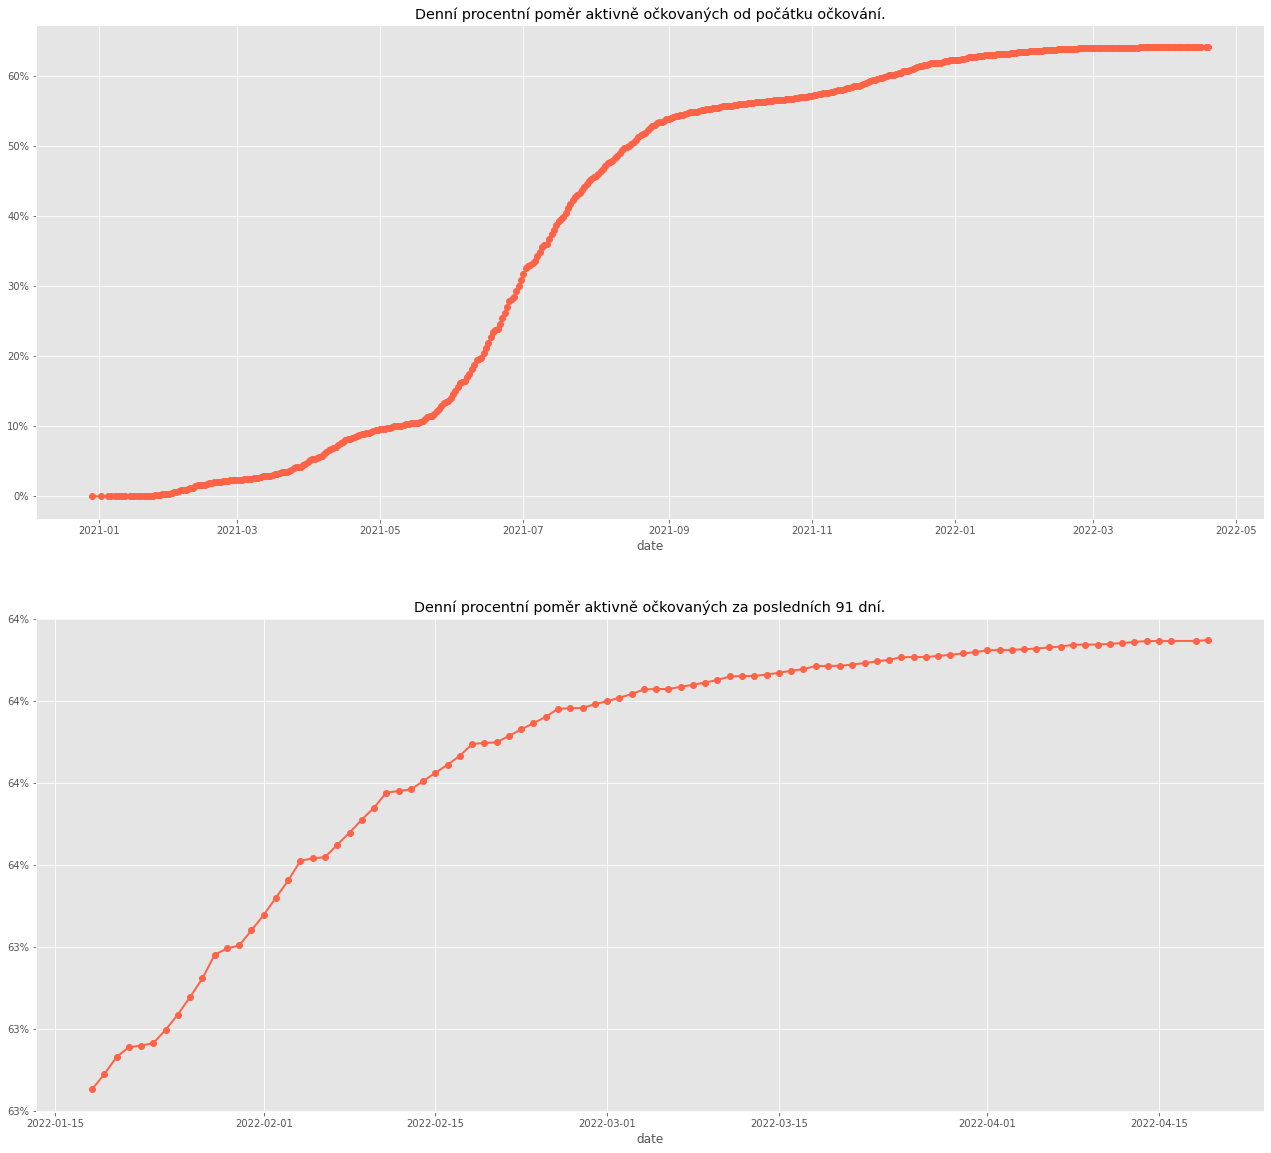

In [5]:
plot_vax_data(vaxs, days_back)

## Vývoj počtu pozitivně testovaných

Za posledních 49 dní zobrazuje:
- denní absolutní počet pozitivně testovaných (nejsou započítány reinfekce) s regresí polynomem 5. stupně 
- __incidence__ - nově nakažení za týden na 100 000 obyvatel - zvlášť pro ČR a pro Prahu
- kumulativní počet pozitivně testovaných od začátku testování - zobrazuje se jen posledních 49 dní

In [6]:
# základni dataframes
df, df_incidence, df_incidence_praha = get_epidemic_data(vaxs, days_back)

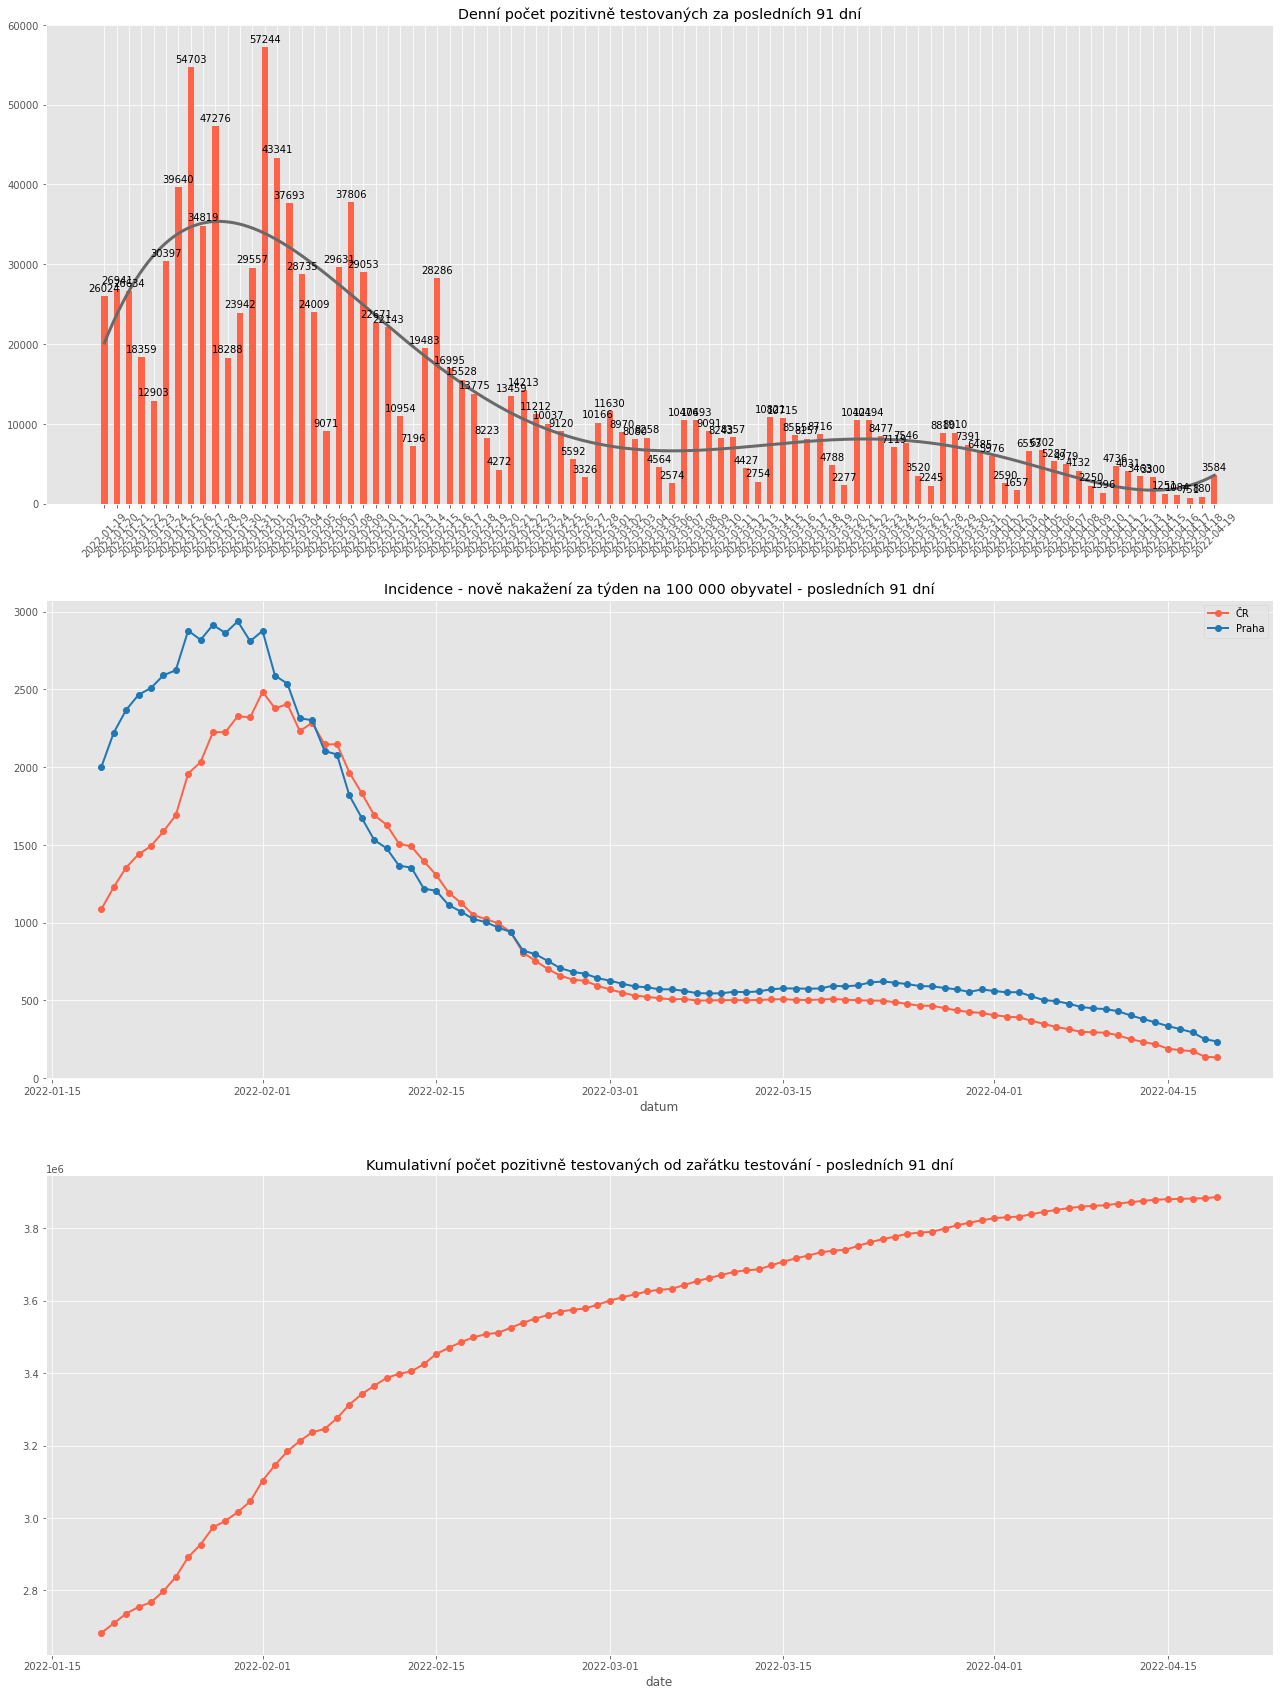

In [7]:
plot_positive_incidence(df, df_incidence, df_incidence_praha, days_back)

### Vývoj denního počtu reinfekcí

Za reinfekci se považuje opakované, potvrzené, symptomatické onemocnění covid-19, kde mezi první a druhou epizodou onemocnění uběhlo 60 nebo více dnů.

TODO:
- přidat poměrné vyjádření vzhledem k počtu nově nakažených

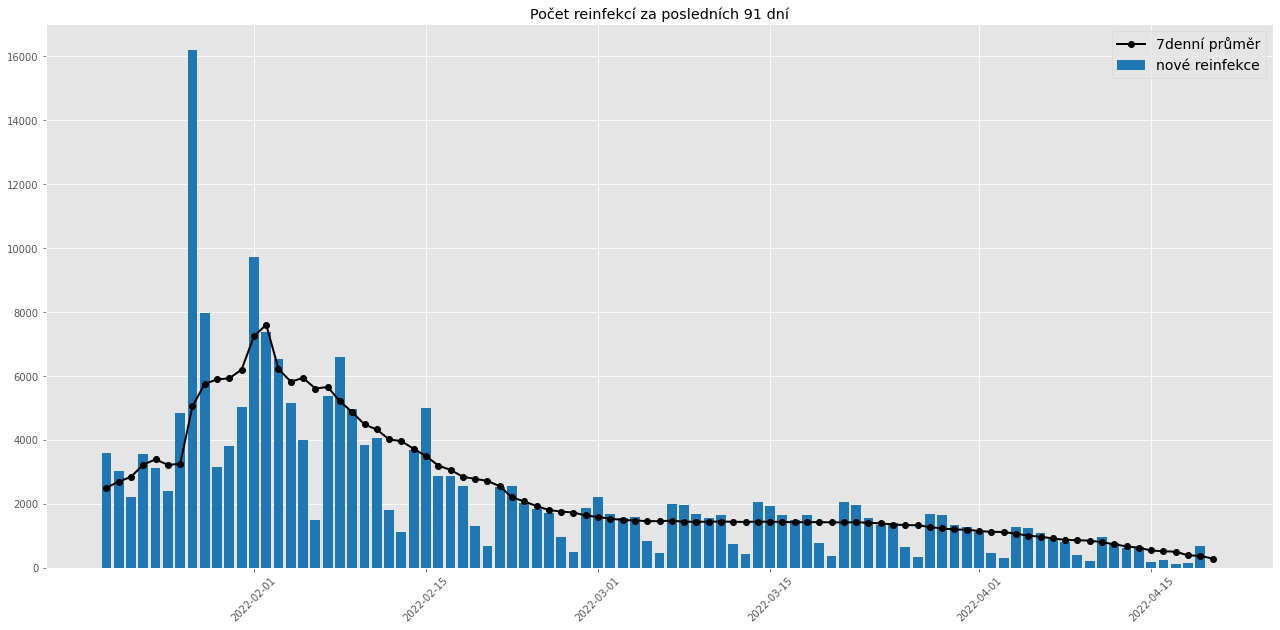

In [8]:
dfr = get_reinfection_data(days_back)
plot_reinfection(dfr, days_back)

## Vývoj počtu testovaných

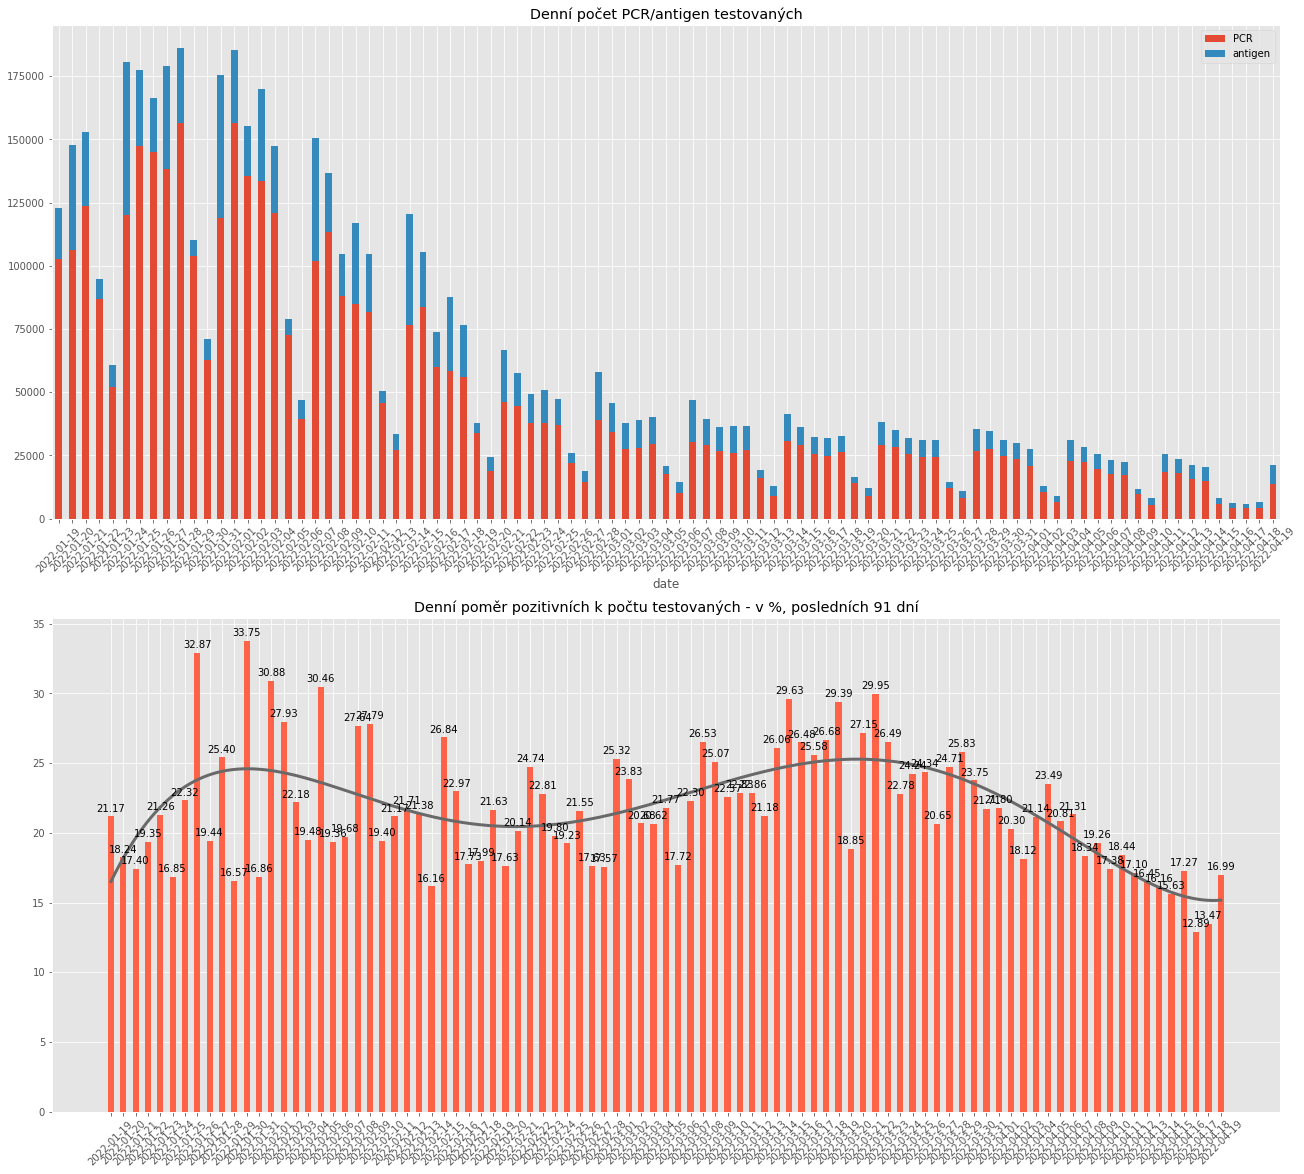

In [9]:
plot_tests(df, days_back)

## Počty uzdravených a zemřelých

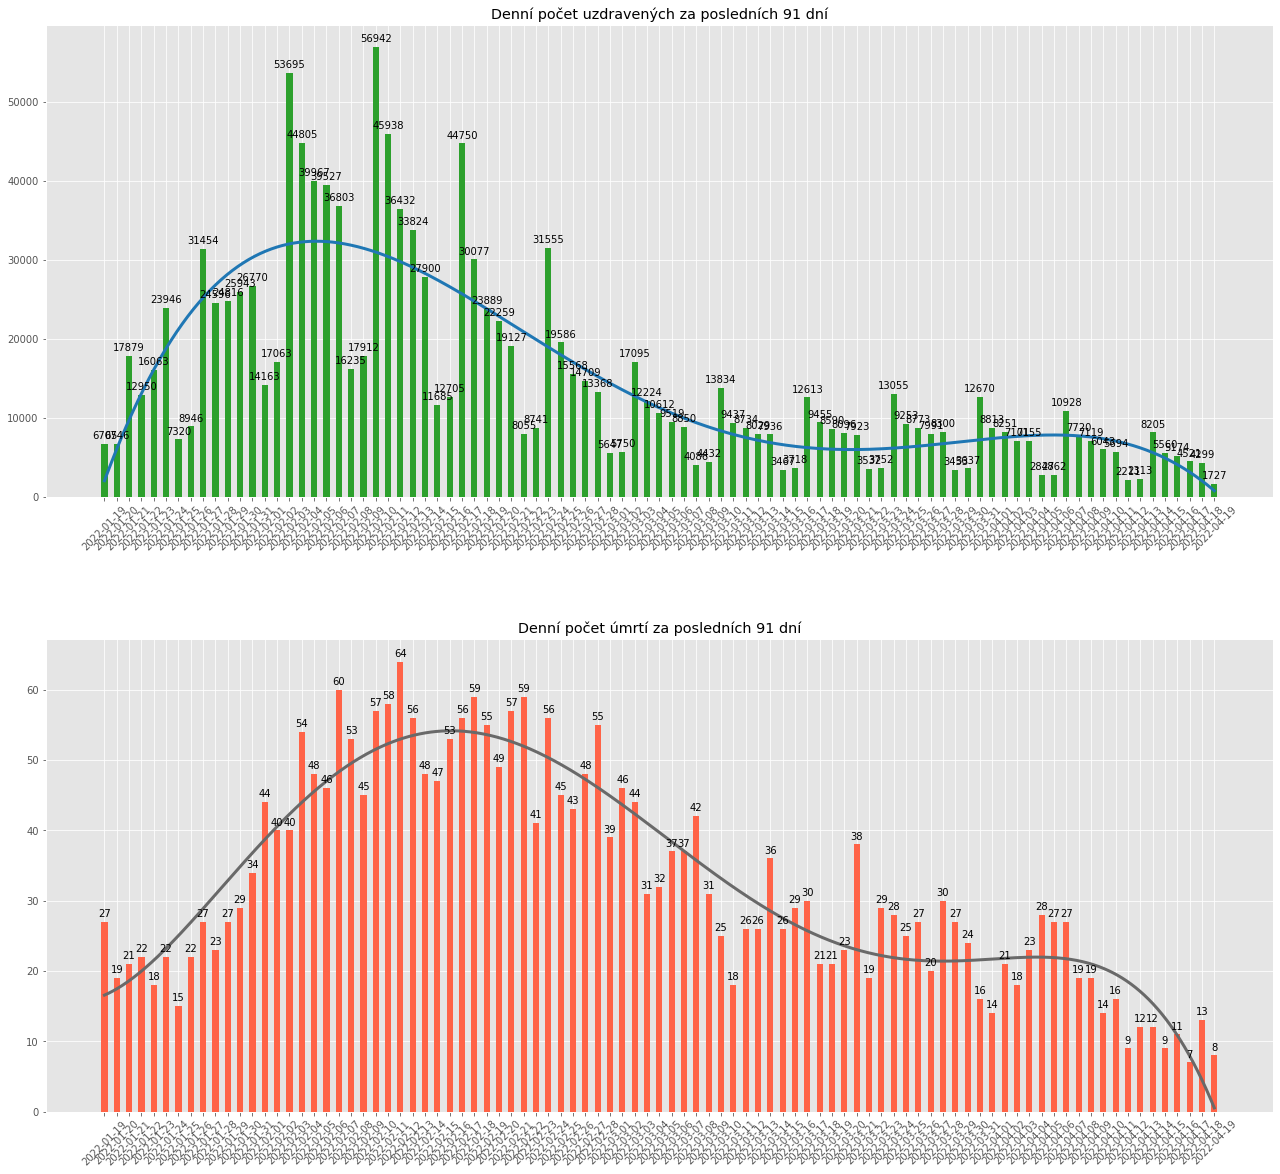

In [10]:
plot_rd(df, days_back)

## Vliv očkování na úmrtí, umístění na JIP, nákazu

Data jsou vážená počtem aktivně očkovaných (dataframe vaxs) vzhledem k celkovému počtu obyvatel podle [ČSÚ](https://www.czso.cz/csu/czso/obyvatelstvo_lide). Aktivně očkovaný znamená plné očkovaní ne starší než 6 měsíců (2 měsíce u Johnson vakcíny) případně booster dávku ne starší než 3 měsíce.

### Vážené počty podle očkovaný/neočkovaný

Denní počty zemřelých a osob na JIP vztaženy k 1 miliónu obyvatel, denní počet nakažených ke 100 tisícům.

TODO:
- vysvětlit co to číslo znamená - je to vztažené k 100 tisícům obyvatel
- předělat poměr na procenta?
- v grafech ukazovat i 7 denní průměrné hodnoty

Velká otázka:
- já si počítám nějak počet aktivně očkovaných
- ale tenhle algoritmus neodpovídá tomu jak očkované počítá ÚZIS a tím pádem, jak je to v datasetech o zemřelých/jip/nakažených
- asi by bylo přesnější použít počet očkovaných přímo od úzisu 
- jak to ale úzis počítá?


In [11]:
df_ocko_umrti, df_ocko_jip, df_ocko_positive = get_epidemic_vax_data(vaxs, days_back)

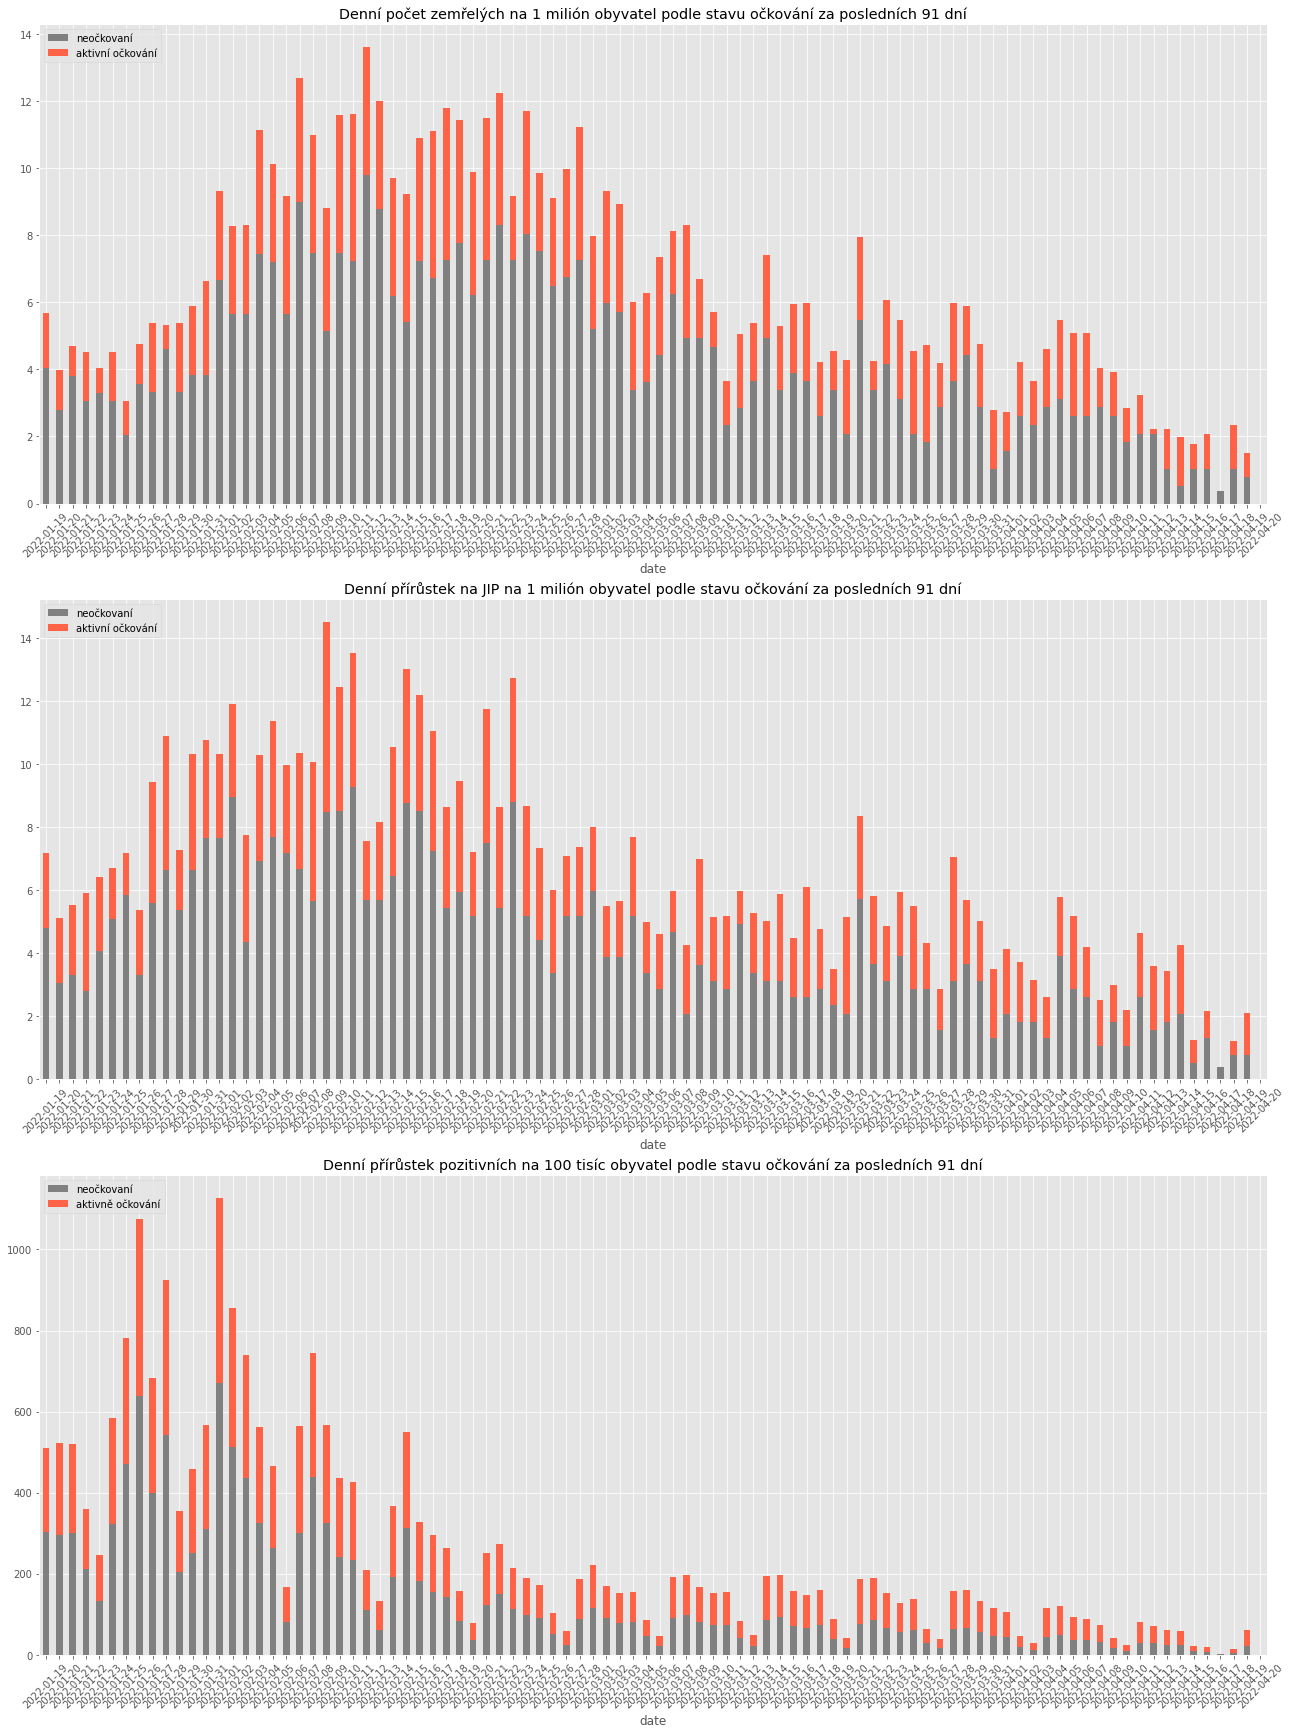

In [12]:
plot_djp_vax(df_ocko_umrti, df_ocko_jip, df_ocko_positive, days_back)

#### Denní vážený poměr počtů neočkovaných vs. aktivně očkovaných pro úmrtí/JIP/nakažené

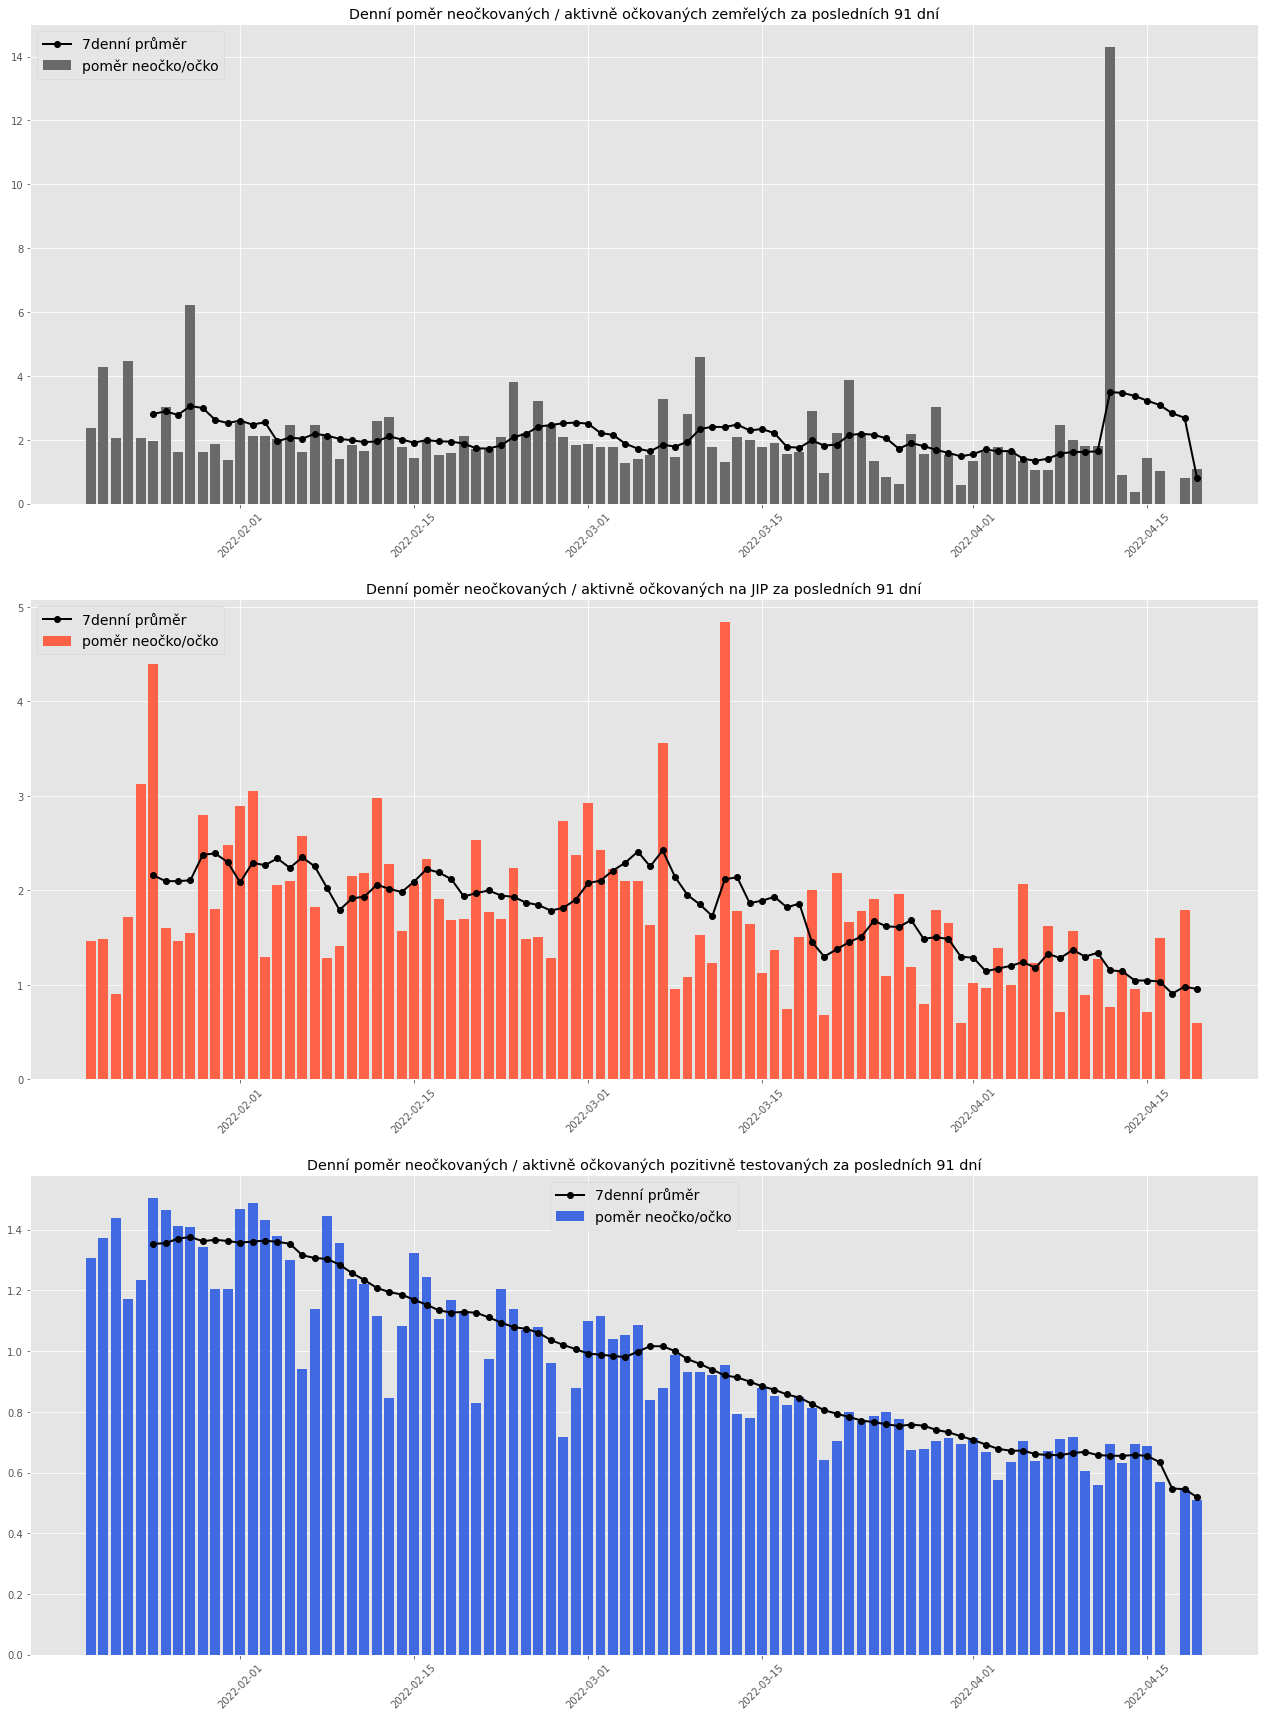

In [13]:
plot_djp_vax_ratio(df_ocko_umrti, df_ocko_jip, df_ocko_positive, days_back)